# Sally's MCMC method to cluster time series trajectories  
This builds on our gentle intro to using mean and variance to cluster timeseries via MCMC (Monte Carlo Markov Chains), in which we add the autoregressive component (AR), and again sample the posterior using Gibbs sampling.

## Method  
***
We want to know the group membership $\gamma_k$ of each individual $y$: where $Pr(\gamma_k=j)$ is the probability that an individual $k$'s time series $y_{k}$ belongs to group $j$. Let's express this as the probability of observing $y_k$ given $\gamma_k: Pr(y_k \mid \gamma_k=j)$  

Our model is:

$$
y_i \mid (\gamma_i=k) \sim \mathcal{N}(\alpha_{0i} + \alpha_{1i}, \sigma^2_k)
$$

where $\alpha_0$ and $\alpha_1$ are the intercept and slope of a regression line between each time point $y_{t}$ and the previous one $y_{t-1}$ for each individual $i$. In this way, the autogressive (AR) dependency between time points is captured by the slope and intercept of the correlation parameters $\alpha$.  

This is a heirarchical model with a level for individuals $i$ and a level for the groups $k$. Thus each $\alpha_0i$ and $\alpha_1i$ is drawn from a normal distribution for that group in the following manner: 
  
$$
\alpha_i \mid (\gamma_i = k) \sim \mathcal{N}(\mu_k, \tau_k)
$$

So we set some initial values for the alphas, sigma, mu and tau and then sample from the posterior (Gibbs Sampling):

1. Draw alpha for each individual given $\gamma = k$  : $\alpha_i  \mid \gamma_i = k \sim Pr(\alpha_i \mid \gamma_i, y_i, \mu_k, \tau_k)$

2. Draw sigma for each group  $\sim Pr(\sigma^2_k \mid \alpha_i, \mu_k, \tau_k)$  
3. Draw mu for each group $ \sim Pr(\mu_k \mid \alpha_i, \tau_k, \sigma^2_k)$  
4. Draw tau for each group $ \sim Pr(\tau_k \mid \alpha_i, \mu_k, \sigma^2_k)$
5. Draw gamma $ \sim Pr(\gamma \mid y_i) = \mathcal{U}[0,1]$  
6. Draw $\pi$ if *u* < $Pr(\gamma_i = \pi)$ then $\gamma_i = 1$ else $\gamma_i = 0$



### Simulated data generation  
***
Setting up some parameters for the artificial data generation...

In [21]:
%% Generate data
clear variables
n = 1000; % number of timeseries (samples)
ntime = 14; % number of time points in the time series
y = zeros(n,ntime+100); % y will hold our data (n timeseries)
prob_true = 0.2; % proportion of timeseries in group2 (mu2, sigma2)
u = rand(n,1);
time = linspace(1, ntime, ntime)';
ncovs = 1;
ngroups = 2;
ind_true = ones(n, 1);

We will draw the samples for each group from a normal distribution with a mean and variance for each parameter...

In [22]:
% draw the samples for group 1 from a normal distribution 
kk1 = find(u > prob_true);
mu01_true = 0.8; % mu of intercept for group 1
mu11_true = 0.2; % mu of slope for group 1
mu02_true = 0.5;
mu12_true = 0.4;
sigma1_true = 0.05;
sigma2_true = 0.15;
tau01_true = 0.001; % variance of intercept for group 1
tau11_true = 0.004; % variance of slope for group 1
tau02_true = 0.001;
tau12_true = 0.004;

% now using these parameters we can draw the slope and intercept for each individual
alpha01_true = normrnd(mu01_true, sqrt(tau01_true), n, 1);
alpha11_true = normrnd(mu11_true, sqrt(tau11_true), n, 1);
alpha02_true = normrnd(mu02_true, sqrt(tau02_true), n, 1);
alpha12_true = normrnd(mu12_true, sqrt(tau12_true), n, 1);

Then we initialise the first time point in the series for group 1 by drawing from:  

$$
\mathcal{N}(\mu_{01}/(1-\mu_{11}), \  \ \sigma_1/\sqrt{(1-\alpha_{11}^2)}
$$
**(nb: what does (1-alpha11^2) do here?)**

In [23]:
y(kk1, 1)=normrnd(alpha01_true(kk1)./(1-alpha11_true(kk1)), ...
                  sigma1_true./sqrt(1-alpha11_true(kk1).^2), ...
                  length(kk1),1);

% and extend to the remaining time points
for j = 2:ntime+100
    y(kk1, j) = normrnd(alpha01_true(kk1)+alpha11_true(kk1).*y(kk1,j-1), ...
                        sigma1_true, ...
                        length(kk1), ...
                        1);
end

% draw the samples for group 2 from another normal in the same way 
kk2 = find(u < prob_true);
ind_true(kk2)=2;

y(kk2, 1) = normrnd(alpha02_true(kk2)./(1-alpha12_true(kk2)),...
                    sigma2_true./sqrt(1-alpha12_true(kk2).^2),...
                    length(kk2),...
                    1);
                   
for j = 2:ntime+100
    y(kk2, j) = normrnd(alpha02_true(kk2)+alpha12_true(kk2).*y(kk2,j-1),...
                        sigma2_true,...
                        length(kk2),...
                        1);
end

Then with the generated time series (length = ntimes + 100) we take the final time points generated and plot the results 

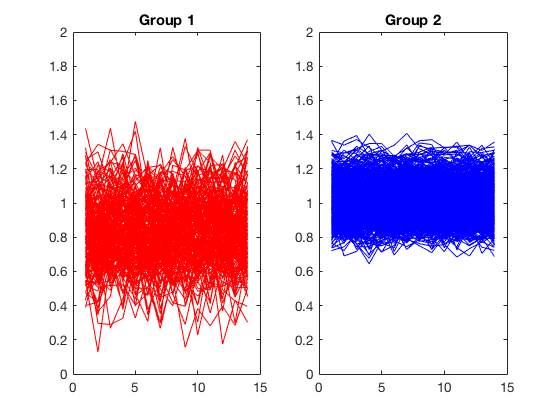

In [24]:
% Take the final time points generated
y=y(:,end-13:end);

% plot the generated timeseries
time=linspace(1, ntime, ntime)';
figure
subplot(1,2,1)
plot(time,y(kk2,:),'r');
ylim([0 2])
title('Group 1')

subplot(1,2,2)
plot(time,y(kk1,:),'b')
ylim([0 2])
title('Group 2')

### MCMC scheme  
***
 
Our recipe in detail is:

1. Draw $\alpha$'s and calculate their conditional likelihood  
    1.1 Randomly assign the group membership of each individual $u_i = Pr(\gamma_k = 0.5)$  
    1.2 Calculate intercept and slope for each individual $\alpha_{0i}, \alpha_{1i}$  
    1.3 Calculate the mean (expected value of mu) and variance (expected value of tau) of the alphas for the group: e.g., $\mu_0 = \frac{1} {n_k} \sum_{i=1}^{n_k} \alpha_{0i}, \ \ \tau_{0} = \sum_{i = 1}^{n_k} (\alpha_{0i} - \mu_{0})^2$  
    1.4 Update the posterior for mu and tau  
    1.4 Draw $\alpha_i$'s from the (posterior?) distribution with those parameters (this is the empirical Bayes step.  
    1.5  
2. Draw $\sigma^2$ for each group  
    2.1 Update posterior $\sigma^2$ for each group  
    2.2 Draw $\sigma^2$ from an inverse gamma function  
3. Draw $\mu$ for each group  
    3.1 Calculate the Likelihood of mu: $\mathcal{L}(\mu) = \frac{1} {n_k} \sum_{i=1}^{n_k} \alpha_{0i}$  
    3.2 Posterior $\mu$ = prior $\mu$ + likelihood $\mu$  
    3.3 Draw new $\mu$ from the posterior distribution
4. Draw tau for each group $ \sim Pr(\tau_k \mid \alpha_i, \beta_i, \mu_k, \sigma^2_k)$
5. Draw gamma $ \sim Pr(\gamma \mid y_i) = \mathcal{U}[0,1]$  
6. Draw $\pi$ if *u* < $Pr(\gamma_i = \pi)$ then $\gamma_i = 1$ else $\gamma_i = 0$

In [26]:
%%file mcmcAR.m
function [ind_iter] = mcmcAR(y)

    %%% Parameters %%%
    n = size(y, 1); % update n
    ngroups = 2;
    ncovs = 1;
    ntime = 14;
    nloop = 1000; % number of iterations
    nwarmup = 500;
    ind_iter = ones(n, nloop+1); % index for group membership in each loop
    
    
    %%% Housekeeping %%%
    % to store the alphas (slopes) in each loop
    alpha_iter = zeros(n, ncovs+1, nloop+1);
    
    % mu_alpha will be mean of coef
    mu_alpha_iter = zeros(ngroups, ncovs+1, nloop+1);
    
    % tau_alpha will be var of coef
    tau_alpha_iter = zeros(ngroups, ncovs+1, nloop+1);
    
    % to store sigmasq in each loop
    sigmasq_iter = zeros(ngroups, nloop+1);
    
    prior_prob_iter = ones(ngroups, nloop+1); % priors
    post_prob_iter = ones(n,ngroups,  nloop+1); % posteriors
    
    %%% Initializing some starting values for MCMC %%%
    u = rand(n, 1); % random starting value for proportion assumed in each group
    kk = u < 0.5; % generate a starting group for each group member 
    ind_iter(kk, 1) = 2; % update the first index with starting group
    
    % Intercept and slope starting values for each individual 
    for k = 1:n    
        y_temp = y(k, 2:ntime)';
        y_lag = y(k, 1:ntime-1)';
        xmat = [ones(ntime-1, 1), y_lag]; % design matrix 
        xdashx = xmat' * xmat; % covariance between timepoints
        alpha_iter(k, :, 1) = xdashx \ (xmat' * y_temp); % intercept & slope 
    end
    
    % Mu, Tau and Sigmasq starting values
    for j = 1:ngroups
        kk = find(ind_iter(:, 1) == j); % was: find(ind_true == j);
        mu_alpha_iter(j, 1, 1) = mean(alpha_iter(kk, 1, 1)); % mean intercept of group
        mu_alpha_iter(j, 2, 1) = mean(alpha_iter(kk, 2, 1)); % mean slope of group
        tau_alpha_iter(j, 1, 1) = var(alpha_iter(kk, 1, 1));
        tau_alpha_iter(j, 2, 1) = var(alpha_iter(kk, 2, 1));
        temp = y(kk, :);
        sigmasq_iter(j, 1) = var(temp(:));
        prior_prob_iter(j, 1) = 1 / ngroups;
        post_prob_iter(:, j, 1) = 1 / ngroups;
    end
    
    %c=n; % Is c used?
    fit_ind = zeros(n, ntime-1, nloop+1);                    % What is fit_ind?
    ydev = zeros(n, ntime-1);                                % What is ydev?
    prior_sig_a = 1;
    prior_sig_b = 1;
    prior_mu_mean = mean(alpha_iter(:, :, 1))';
    prior_mu_prec = diag(0.01 ./ var(alpha_iter(:, :, 1))'); % precision
    prior_tau_a = 1;
    prior_tau_b = 1;
    prior_tau_uplim = 4 * range(alpha_iter(:, :, 1)).^2;
    ylag = y(:, 1:ntime-1);


    %% Starting MCMC scheme
    for p = 1:nloop

        % Drawing alphas from a Normal
        for i = 1:n % for each individual (n = 1000)

            j = ind_iter(i, p);
            y_ind = y(i, 2:ntime)';
            xmat = [ones(ntime-1, 1), y(i, 1:ntime-1)']; % design matrix
            xdashx = xmat' * xmat; % Intercept and slope for each individual
            % draw a random mu and sigma from the same distribution 
            alpha_prior_mean = mu_alpha_iter(j, :, p)';
            alpha_prior_prec = diag(1 ./ tau_alpha_iter(j, :, p));
            alpha_like_mean = xdashx \ (xmat' * y_ind);
            alpha_like_prec = xdashx / sigmasq_iter(j,p);
            alpha_post_prec = alpha_like_prec + alpha_prior_prec;
            alpha_post_var = inv(alpha_post_prec);
            alpha_post_mean = alpha_post_prec \ ...
                (alpha_like_prec*alpha_like_mean + alpha_prior_prec*alpha_prior_mean);
            % Drawing alphas here
            alpha_iter(i, :, p+1) = mvnrnd(alpha_post_mean, alpha_post_var);
            fit_ind(i, :, p+1) = xmat * alpha_iter(i, :, p+1)';
            ydev(i, :) = y_ind - fit_ind(i, :, p+1)';
        end
        
        % Drawing sigmasq from an inverse Gamma
        for k = 1:ngroups
            kk = find(ind_iter(:, p) == k);
            nk = length(kk);
            post_sig_a = (ntime-1) * nk/2 + prior_sig_a;
            post_sig_b = sum(sum(ydev(kk, :).^2)) / 2 + prior_sig_b;
            sigmasq_iter(k, p+1) = 1 ./ gamrnd(post_sig_a, 1/post_sig_b);

        % Drawing mu for the parametric part of random effects (What are the 
        % random effects here? The individual level slope and intercepts?)      
            if (nk == 0)
                post_mu_mean = prior_mu_mean;
                post_mu_var = inv(prior_mu_prec);
            else
                like_mu_mean = mean(alpha_iter(kk, :, p+1))';
                like_mu_prec = diag(nk ./ tau_alpha_iter(k, :, p));
                post_mu_prec = like_mu_prec + prior_mu_prec;
                post_mu_var = eye(ncovs + 1) / post_mu_prec;
                post_mu_mean = post_mu_var * ...
                    (prior_mu_prec*prior_mu_mean + like_mu_prec*like_mu_mean);
            end
            
            mu_alpha_iter(k, :, p+1) = mvnrnd(post_mu_mean, post_mu_var);

         % Drawing tau from a Gamma???
            tau_beta_a = nk/2 + prior_tau_a;
            tau_beta_b = sum(...
                            (alpha_iter(kk, :, p+1) - ...
                            (mu_alpha_iter(k, :, p+1)' * ...
                             ones(1, nk))').^2) + ...
                         prior_tau_b;
            u = rand(ncovs+1, 1);
            const1 = gamcdf(1 ./ prior_tau_uplim', ...
                            tau_beta_a * ones(ncovs+1, 1), ...
                            1 ./ tau_beta_b');
            const2 = ones(ncovs+1, 1) - u.*(ones(ncovs+1, 1) - const1);
            tau_alpha_iter(k, :, p+1) = 1./gaminv(const2, ...
                                                  ones(ncovs+1, 1) * tau_beta_a, ...
                                                  1./tau_beta_b');
        end
        
        % Evaluate the likelihood the data was drawn from the above distributions
        like = zeros(n, ngroups);
        for j = 1:ngroups % for each group (1 and 2)
            % Calculate the likelihood of each timeseries in each distribution

            like_group = prod(normpdf(ydev, ...
                                      zeros(n, ntime-1), ...
                                      sqrt(sigmasq_iter(j,p+1))*ones(n,ntime-1)),...
                                      2);
            % (like is likelihood score for each timeseries)
            %
            % numerator for Bayes rule:   
            numer(:, j) = like_group * prior_prob_iter(j, p);
        end

        % denominator for Bayes rule:
        denom = sum(numer, 2);

        % Calculate the posterior (Bayes rule)
        for j = 1:ngroups
            post_prob_iter(:, j, p+1) = numer(:, j) ./ denom;
        end

        % Update the group membership acccording to the posterior for each group
        u = rand(n, 1); % random threshold (why does this work???)
        kk = post_prob_iter(:, j, p+1) > u;
        ind_iter(:, p+1) = 1;
        ind_iter(kk, p+1) = 2;

        % Update the prior for each group <Slot in Davids code about here>
        prior_prob_iter(2, p+1) = betarnd(sum(kk), n-sum(kk));
        prior_prob_iter(1, p+1) = 1 - prior_prob_iter(2, p+1);

    end
end

Created file '/Users/rich/Dropbox/RichardSallyNickTrajModels/results/mcmcAR.m'.


### Testing on simulated data

In [27]:
ind_iter = mcmcAR(y);

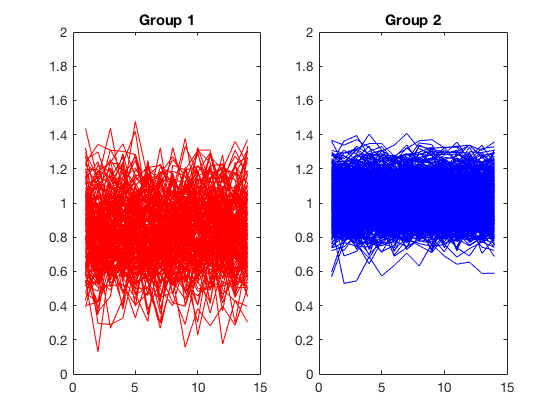

In [28]:
%% plot the revealed groups
time=linspace(1, ntime, ntime)';
prob_hat = mean(ind_iter-1, 2);
idx = prob_hat > 0.5;
figure
subplot(1, 2, 1)
plot(time, y(idx, :), 'r');
ylim([0 2])
xlim([0 15])
title('Group 1')

subplot(1, 2, 2)
plot(time, y(~idx, :), 'b')
ylim([0 2])
xlim([0 15])
title('Group 2')

#### Conclusions from simulated data:  
Two groups are recovered (which is not surprising since we only allowed for two groups in the algorithm). Accuracy and specificity tests to be done.

## Now let's try some real data (MH-I5 scores from HILDA)

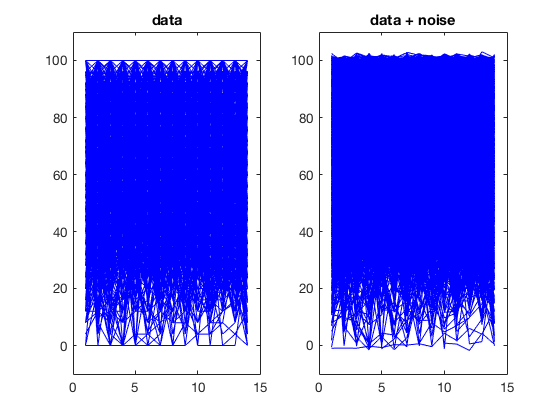

In [30]:
%% ...Or load the mental health scores from HILDA
run('../import_ghmhcleancsv.m')
y = ghmh;

% Add noise to the scores
noise = randn(size(y));
yd = y + noise;

subplot(1,2,1)
plot(time, y, 'b')
ylim([-10 110])
xlim([0 15])
title('data')
subplot(1,2,2)
plot(time, yd, 'b')
ylim([-10 110])
xlim([0 15])
title('data + noise')

In [11]:
ind_iter = mcmcAR(yd);

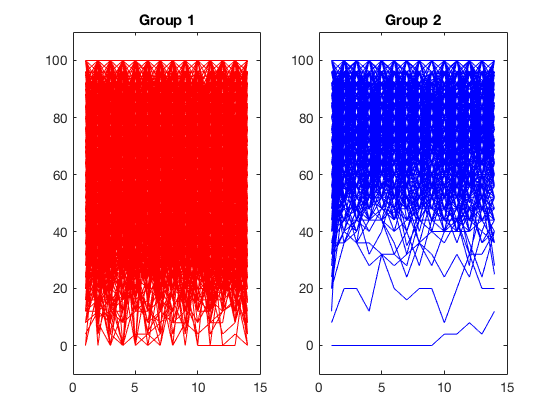

In [12]:
%% plot the revealed groups
time=linspace(1, ntime, ntime)';
idx = ind_iter(:, end) == 1;
figure
subplot(1,2,1)
plot(time,y(idx,:),'r');
ylim([-10 110])
xlim([0 15])
title('Group 1')
subplot(1,2,2)
plot(time,y(~idx,:),'b');
ylim([-10 110])
xlim([0 15])
title('Group 2')

## Conclusions:  
Two groups are recovered. **Note that Group 2 (blue) has a higher mean and less variance than Group 1 (red), consistent with a** ***superwell group***. Presumably this occured by chance, since we haven't provided any restrictions to ensure this outcome (i.e., I don't know why this occurred!)

#### Compare to kmeans

In [17]:
idx = kmeans(y, 2);

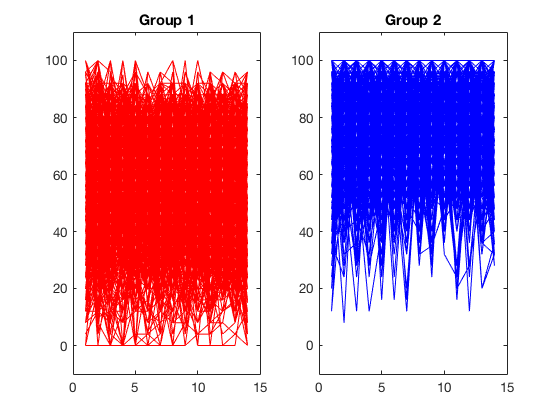

In [18]:
%% plot the revealed groups
time=linspace(1, ntime, ntime)';
idx = idx == 1;
figure
subplot(1,2,1)
plot(time,y(idx,:),'r');
ylim([-10 110])
xlim([0 15])
title('Group 1')
subplot(1,2,2)
plot(time,y(~idx,:),'b');
ylim([-10 110])
xlim([0 15])
title('Group 2')